"""
EEG Connectivity Analysis Script

This script takes pre-processed EEG data, computes  coherence between EEG channels, and visualizes the results.
Computes group-level averages and statistical significance. Subject specific analysis possible.
It integrates MNE for EEG analysis, Brainspace and Nilearn for surface-based processing, and BrainStat for parcellation.  

### Key Steps:
1. **Load EEG Data:** Uses MNE to read and preprocess EEG data.
2. **Compute Correlation Matrices:** Constructs connectivity matrices from EEG signals. Current method is coherence.
Other methods such as 'plv', 'pli', 'wpli', etc. possible by changyng <method='coh'> in line 125 for 1 subject 
and line 196 for group level (lines 9 and 32 in each block in jupiter notebook)
3. **Statistical Analysis:** Applies correlation metrics and visualizes results with seaborn and matplotlib.
4. **Visualization** – Generates heatmaps for EC, EO, difference matrices, and significance if applicable.

Please check chdir in line 61 (import block line 35)

Authors: Marian Simarro gonzalez@cbs.mpg.de
Last Updated: March 2025
"""

# Import block

In [ ]:
# Load packages
import os
import sys
from datetime import datetime
import json

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import pandas as pd
import seaborn as sns
from scipy import signal, stats
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

!pip install networkx
import networkx as nx

from sklearn.covariance import GraphicalLassoCV

!pip install nilearn
from nilearn import plotting

!pip install mne
!pip install mne_connectivity

import mne
from mne.minimum_norm import apply_inverse, make_inverse_operator
from mne.stats import permutation_cluster_test
from mne_connectivity import SpectralConnectivity
from mne_connectivity import spectral_connectivity_epochs
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.viz import circular_layout

os.chdir("C:/Users/Marianne/Downloads/Lemon/")  # Change to your actual folder where little_helpers.py and config.py files are
sys.path.append(os.getcwd())  # Ensure the current directory is added to the path
import config
from config import subjects, subjects_list, conditions, matrix_type, con_folder, corr_folder, input_folder

c:\Python39\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


    fonttools (>=3.0<4.0) ; (python_version < "3") and extra == 'with-fonttools'
              ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# List subjects to analyse 
# subjects = ["032304", "032305"]   # Set to all by default. Compleate "subjects_list" stored in config
# You can also analyse only one condition by changing the "conditions" parameter 
# e.g. condition = "EC"

Check subject data

In [ ]:
# Iterate through subject files
for subject in subjects:
    for condition in ['EO', 'EC']:
        """ 
        This will load the EEG data for the subject or subjects selected and display:
        Sampling rate
        Number of channels
        Electrode positions
        """
        file_path = os.path.join(input_folder, f"{subject}_{condition}.set")
        
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue  # Skip to the next file if not found
        
        # Load EEG data
        data = mne.io.read_raw_eeglab(file_path, preload=True)

        # Print general info
        print(data.info)

        # Get data info
        sfreq = data.info['sfreq']
        ch_names = data.ch_names
        n_channels = len(ch_names)

        # Extract events
        events, event_id = mne.events_from_annotations(data)

        # Ensure event_id contains the key 2 before proceeding
        if 2 in event_id.values():
            epochs = mne.Epochs(data, events, event_id=2, tmin=-1, tmax=2, 
                                baseline=(-0.5, 0), preload=True, reject=dict(eeg=2e-4))
        else:
            print(f"Event ID 2 not found for {subject} {condition}. Skipping epochs creation.")

File not found: /data/tu_gonzalez/MPI-Leipzig-Mind-Brain-Body/subjects/sub-032304/ses-01/sub-032304_EO.set
File not found: /data/tu_gonzalez/MPI-Leipzig-Mind-Brain-Body/subjects/sub-032304/ses-01/sub-032304_EC.set


# Connectivity

## For one subject

In [ ]:
# Extract epochs if needed (adjust parameters as necessary)
epochs = mne.make_fixed_length_epochs(data, duration=2.0, overlap=0.5)

# Calculate connectivity
""" Calculate connectivity using imaginary coherence for 1 subject "(data)"
    """
con = spectral_connectivity_epochs(
    epochs.get_data(),
    method='coh',  # Options: 'coh', 'plv', 'pli', 'wpli', etc.
    mode='multitaper',
    sfreq=data.info['sfreq'],
    #n_nodes=n_channels,
    #fmin=8, fmax=13,  # Alpha band example
    faverage=True,
    n_jobs=1
)

# Extract connectivity matrix
con_matrix = con.get_data(output='dense')[:, :, 0]

# Save as a dictionary
coh_data = {
    'correlation_matrix': con_matrix,
    'ch_names': ch_names
    }        

# Save to a .npy file
np.save(os.path.join(con_folder,"coh_connectivity_matrix.npy"), con_matrix)

print("Connectivity matrix saved successfully!")

Reading C:\Users\Marianne\Downloads\Lemon\subjects\ses-01\sub-032304_EC.fdt
Reading 0 ... 119999  =      0.000 ...   479.996 secs...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_2992\3217423539.py:4: RuntimeWarning: Data file name in EEG.data (sub-010005_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032304_EC.fdt).
  data = mne.io.read_raw_eeglab(eeg_file, preload=True)


Not setting metadata
319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 319 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_2992\3217423539.py:4: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(eeg_file, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_2992\3217423539.py:4: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(eeg_file, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

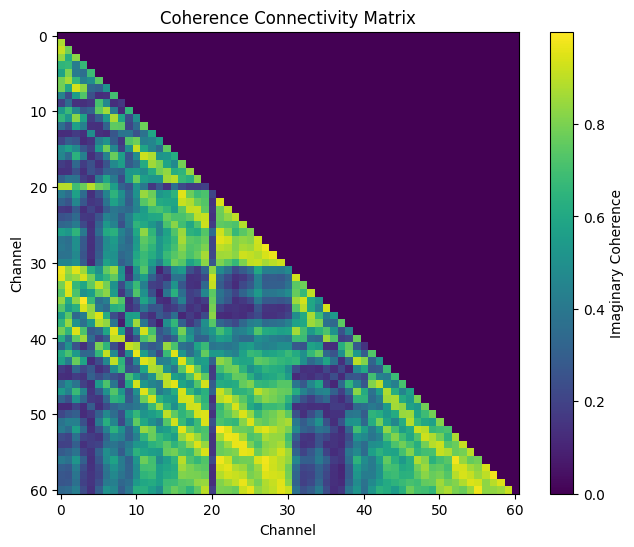

In [ ]:
# Plot
plt.figure(figsize=(8, 6))
plt.imshow(con_matrix, cmap='viridis', interpolation='none')
plt.colorbar(label="Imaginary Coherence")
plt.xlabel("Channel")
plt.ylabel("Channel")
plt.title("Coherence Connectivity Matrix")
plt.show()

In [25]:
print(con_matrix)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.87700306 0.         0.         ... 0.         0.         0.        ]
 [0.91307301 0.78169866 0.         ... 0.         0.         0.        ]
 ...
 [0.27217387 0.25938735 0.38676693 ... 0.         0.         0.        ]
 [0.26587495 0.27574566 0.36893983 ... 0.94859328 0.         0.        ]
 [0.33483661 0.34901813 0.42499782 ... 0.8543312  0.92022051 0.        ]]


## For multiple subjects

In [ ]:
# make lists
ec_conn_list = []
eo_conn_list = []

            
# Iterate through subject files
for subject in subjects:
    for condition in ['EO', 'EC']:  # Eyes Open and Eyes Closed
        """
        Load Data and Compute PSD:
        For each subject and condition (EO/EC), load the EEG data
        and compute the Power Spectral Density (PSD) using Welch's method.
        Ensure consistent parameters (e.g., fmax=100)
        to maintain frequency resolution.
        """
        file_path = os.path.join(input_folder, f"{subject}_{condition}.set")
        data = mne.io.read_raw_eeglab(file_path, preload=True)        

        # Get data info
        sfreq = data.info['sfreq']
        ch_names = data.ch_names
        print(len(ch_names))
        
        # Extract epochs if needed (adjust parameters as necessary)
        epochs = mne.make_fixed_length_epochs(data, duration=2.0, overlap=0.5)

        # Calculate connectivity
        """ Calculate connectivity using imaginary coherence
                """
        con = spectral_connectivity_epochs(
            epochs.get_data(),
            method='coh',  # Options: 'coh', 'plv', 'pli', 'wpli', etc.
            mode='multitaper',
            sfreq=data.info['sfreq'],
            #n_nodes=n_channels,
            #fmin=8, fmax=13,  # Alpha band example
            faverage=True,
            n_jobs=1
            )

        # Extract connectivity matrix
        con_matrix = con.get_data(output='dense')[:, :, 0]
        
        # Store matrix for each condition
        if condition == 'EC':
            ec_conn_list.append({
                'subject': subject,  
                'matrix': con_matrix,
                'ch_names': ch_names
                })
        elif condition == 'EO':
            eo_conn_list.append({
                'subject': subject,
                'matrix': con_matrix,
                'ch_names': ch_names
                })
                      
        # Save to a .npy file
        np.save(os.path.join(con_folder,f"{subject}_{condition}_coh_matrix.npy"), con_matrix)
        
        print(f"Data for {subject} - {condition} saved!")


Reading C:\Users\Marianne\Downloads\Lemon\subjects\ses-01\sub-032304_EO.fdt


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010005_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032304_EO.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


Reading 0 ... 119821  =      0.000 ...   479.284 secs...
61
Not setting metadata
319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 319 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010005_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032304_EC.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


61
Not setting metadata
319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 319 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010006_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032305_EO.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


61
Not setting metadata
293 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 293 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010006_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032305_EC.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


60
Not setting metadata
309 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 309 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1770 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010007_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032306_EO.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


57
Not setting metadata
317 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 317 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1596 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010007_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032306_EC.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


57
Not setting metadata
319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 319 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1596 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010010_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032307_EO.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


59
Not setting metadata
306 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 306 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1711 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010010_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032307_EC.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


59
Not setting metadata
317 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 317 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1711 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010012_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032308_EO.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


61
Not setting metadata
315 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 315 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010012_EC.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032308_EC.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


61
Not setting metadata
319 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 319 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1830 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Data file name in EEG.data (sub-010016_EO.fdt) is incorrect, the file name must have changed on disk, using the correct file name (sub-032310_EO.fdt).
  data = mne.io.read_raw_eeglab(file_path, preload=True)


59
Not setting metadata
318 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 318 events and 500 original time points ...


C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  data = mne.io.read_raw_eeglab(file_path, preload=True)
C:\Users\Marianne\AppData\Local\Temp\ipykernel_14128\1089155290.py:20: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  data = mne.io.read_raw_eeglab(file_path, preload=True)


0 bad epochs dropped
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 1711 connections
    using t=0.000s..1.996s for estimation (500 points)
    frequencies: 2.5Hz..125.0Hz (246 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: Coherence
    computing cross-spectral density for epoch 1
    computing cross-spectral density for epoch 2
    computing cross-spectral density for epoch 3
    computing cross-spectral density for epoch 4
    computing cross-spectral density for epoch 5
    computing cross-spectral density for epoch 6
    computing cross-spectral density for epoch 7
    computing cross-spectral density for epoch 8
    computing cross-spectral density for epoch 9
    computing cross-spectral density for epoch 10
    computing cross-spectral density for epoch 11
    computing cross-spectral density for epoc

### Plotting

In [29]:
def plot_connectivity_matrix(matrix, title, ax=None, vmin=None, vmax=None, cmap='viridis'):
    """
    Plot a single connectivity matrix with proper formatting.
    
    Parameters:
    -----------
    matrix : numpy.ndarray
        The connectivity matrix to plot
    title : str
        Title of the plot
    ax : matplotlib.axes, optional
        Axes to plot on, if None a new figure is created
    vmin, vmax : float, optional
        Min and max values for color scaling
    cmap : str, optional
        Colormap to use
    
    Returns:
    --------
    ax : matplotlib.axes
        The axes with the plot
    im : matplotlib.image.AxesImage
        The image for colorbar creation
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        
    # Plot the matrix
    im = ax.imshow(matrix, cmap=cmap, aspect='equal', vmin=vmin, vmax=vmax)
    
    # Add labels and title
    ax.set_title(title)
    ax.set_xlabel('Channels')
    ax.set_ylabel('Channels')
    
    """ # Add grid lines
    n_channels = matrix.shape[0]
    ax.set_xticks(np.arange(-.5, n_channels, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n_channels, 1), minor=True)
    ax.grid(which='minor', color='w', linestyle='-', linewidth=0.5)"""
    
    # Set ticks
    if n_channels <= 25:  # Only show all ticks for small matrices
        ax.set_xticks(np.arange(n_channels))
        ax.set_yticks(np.arange(n_channels))
    else:
        # For larger matrices, show fewer ticks
        step = max(1, n_channels // 10)
        ax.set_xticks(np.arange(0, n_channels, step))
        ax.set_yticks(np.arange(0, n_channels, step))
    
    return ax, im

def plot_subject_comparison(ec_matrix, eo_matrix, subject_id, ch_names=None, output_dir=None):
    """
    Plot comparison of EC and EO connectivity matrices for a single subject.
    
    Parameters:
    -----------
    ec_matrix : numpy.ndarray
        Eyes closed connectivity matrix
    eo_matrix : numpy.ndarray
        Eyes open connectivity matrix
    subject_id : str
        Subject identifier
    ch_names : list, optional
        Channel names
    output_dir : str, optional
        Directory to save plot, if None plot is not saved
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Find global min and max for consistent color scaling
    vmin = min(np.min(ec_matrix), np.min(eo_matrix))
    vmax = max(np.max(ec_matrix), np.max(eo_matrix))
    
    # Plot each matrix
    ax1, im1 = plot_connectivity_matrix(ec_matrix, f"Subject {subject_id} - Eyes Closed", 
                                        ax=axes[0], vmin=vmin, vmax=vmax, cmap='viridis')
    ax2, im2 = plot_connectivity_matrix(eo_matrix, f"Subject {subject_id} - Eyes Open", 
                                        ax=axes[1], vmin=vmin, vmax=vmax, cmap='viridis')
    
    # Calculate and plot difference
    diff_matrix = ec_matrix - eo_matrix
    diff_vmax = max(abs(np.min(diff_matrix)), abs(np.max(diff_matrix)))
    ax3, im3 = plot_connectivity_matrix(diff_matrix, f"Difference (EC - EO)", 
                                        ax=axes[2], vmin=-diff_vmax, vmax=diff_vmax, cmap='coolwarm')
    
    # Add colorbars
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Coherence')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Coherence')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='Difference')
    
    # Add channel labels if provided
    if ch_names is not None and len(ch_names) == ec_matrix.shape[0]:
        if len(ch_names) <= 25:  # Only show all labels for small matrices
            for ax in axes:
                ax.set_xticks(np.arange(len(ch_names)))
                ax.set_yticks(np.arange(len(ch_names)))
                ax.set_xticklabels(ch_names, rotation=45, ha="right")
                ax.set_yticklabels(ch_names)

    plt.tight_layout()
    
    # Save figure if output directory is provided
    if output_dir is not None:
        plt.savefig(os.path.join(output_dir, f"subject_{subject_id}_connectivity.png"), 
                   dpi=300, bbox_inches='tight')
    plt.show()    
    return fig

def plot_group_average(ec_conn_list, eo_conn_list, ch_names=None, output_dir=None):
    """
    Plot group-level average connectivity matrices.
    
    Parameters:
    -----------
    ec_conn_list : list of numpy.ndarray
        List of eyes closed connectivity matrices
    eo_conn_list : list of numpy.ndarray
        List of eyes open connectivity matrices
    ch_names : list, optional
        Channel names
    output_dir : str, optional
        Directory to save plot, if None plot is not saved
    """
    # Calculate averages
    ec_avg = np.mean(np.array(ec_conn_list), axis=0)
    eo_avg = np.mean(np.array(eo_conn_list), axis=0)
    
    # Calculate statistical difference (t-test)
    t_values = np.zeros_like(ec_avg)
    p_values = np.zeros_like(ec_avg)
    
    for i in range(ec_avg.shape[0]):
        for j in range(ec_avg.shape[1]):
            ec_values = [mat[i, j] for mat in ec_conn_list]
            eo_values = [mat[i, j] for mat in eo_conn_list]
            t, p = stats.ttest_rel(ec_values, eo_values)
            t_values[i, j] = t
            p_values[i, j] = p
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Find global min and max for consistent color scaling for the averages
    vmin = min(np.min(ec_avg), np.min(eo_avg))
    vmax = max(np.max(ec_avg), np.max(eo_avg))
    
    # Plot average matrices
    ax1, im1 = plot_connectivity_matrix(ec_avg, "Group Average - Eyes Closed", 
                                       ax=axes[0, 0], vmin=vmin, vmax=vmax)
    ax2, im2 = plot_connectivity_matrix(eo_avg, "Group Average - Eyes Open", 
                                       ax=axes[0, 1], vmin=vmin, vmax=vmax)
    
    # Plot difference
    diff_avg = ec_avg - eo_avg
    diff_vmax = max(abs(np.min(diff_avg)), abs(np.max(diff_avg)))
    ax3, im3 = plot_connectivity_matrix(diff_avg, "Average Difference (EC - EO)", 
                                        ax=axes[1, 0], vmin=-diff_vmax, vmax=diff_vmax, cmap='coolwarm')
    
    # Plot p-values (with threshold)
    p_threshold = 0.05
    p_values_masked = np.ma.masked_where(p_values > p_threshold, p_values)
    ax4, im4 = plot_connectivity_matrix(-np.log10(p_values), "Statistical Significance (-log10(p))", 
                                       ax=axes[1, 1], vmin=0, vmax=4, cmap='plasma')
    
    # Add p-value threshold line to colorbar
    cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04, label='-log10(p-value)')
    cbar4.ax.axhline(-np.log10(p_threshold), color='r', lw=2)
    
    # Add other colorbars
    plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04, label='Coherence')
    plt.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04, label='Coherence')
    plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04, label='Difference')
    
    # Add channel labels if provided
    if ch_names is not None and len(ch_names) == ec_avg.shape[0]:
        if len(ch_names) <= 25:  # Only show all labels for small matrices
            for ax in axes.flat:
                ax.set_xticks(np.arange(len(ch_names)))
                ax.set_yticks(np.arange(len(ch_names)))
                ax.set_xticklabels(ch_names, rotation=45, ha="right")
                ax.set_yticklabels(ch_names)
    
    plt.tight_layout()
    
    # Save figure if output directory is provided
    if output_dir is not None:
        plt.savefig(os.path.join(output_dir, "group_average_connectivity.png"), 
                   dpi=300, bbox_inches='tight')
    plt.show()    
    return fig

def plot_all_subjects_and_group(ec_conn_list, eo_conn_list, subjects, ch_names=None, output_dir=None):
    """
    Plot individual subjects and group average in one workflow.
    
    Parameters:
    -----------
    ec_conn_list : list of numpy.ndarray
        List of eyes closed connectivity matrices
    eo_conn_list : list of numpy.ndarray
        List of eyes open connectivity matrices
    subjects : list of str
        List of subject identifiers
    ch_names : list, optional
        Channel names
    output_dir : str, optional
        Directory to save plots, if None plots are not saved
    """
    # Create output directory if needed
    if output_dir is not None and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Plot each subject
    for i, subject in enumerate(subjects):
        plot_subject_comparison(ec_conn_list[i], eo_conn_list[i], subject, ch_names, output_dir)
    
    # Plot group average
    plot_group_average(ec_conn_list, eo_conn_list, ch_names, output_dir)

    print(f"Plotting complete! {len(subjects)} subjects processed.")


Channels being removed: {'PO4', 'POz', 'PO8', 'PO3'}
Aligned matrices shape: (57, 57)
Channels being removed: {'PO4', 'POz', 'PO8', 'PO3'}
Aligned matrices shape: (57, 57)


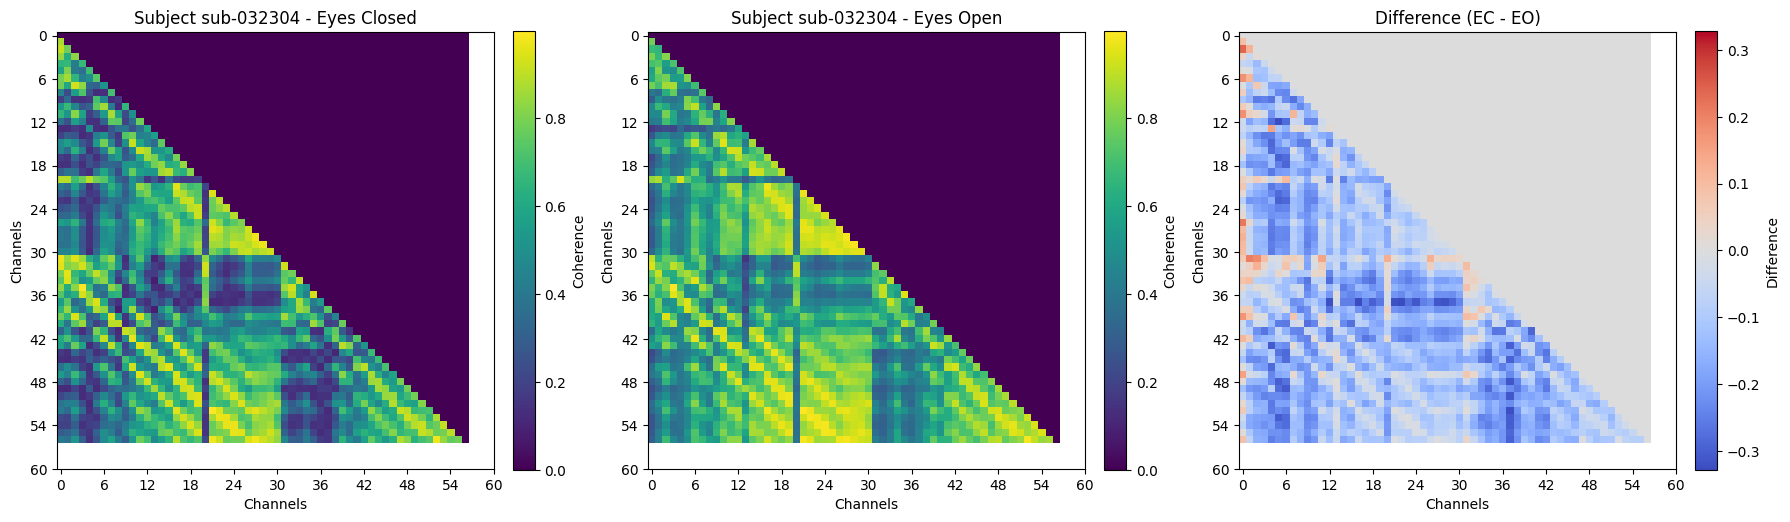

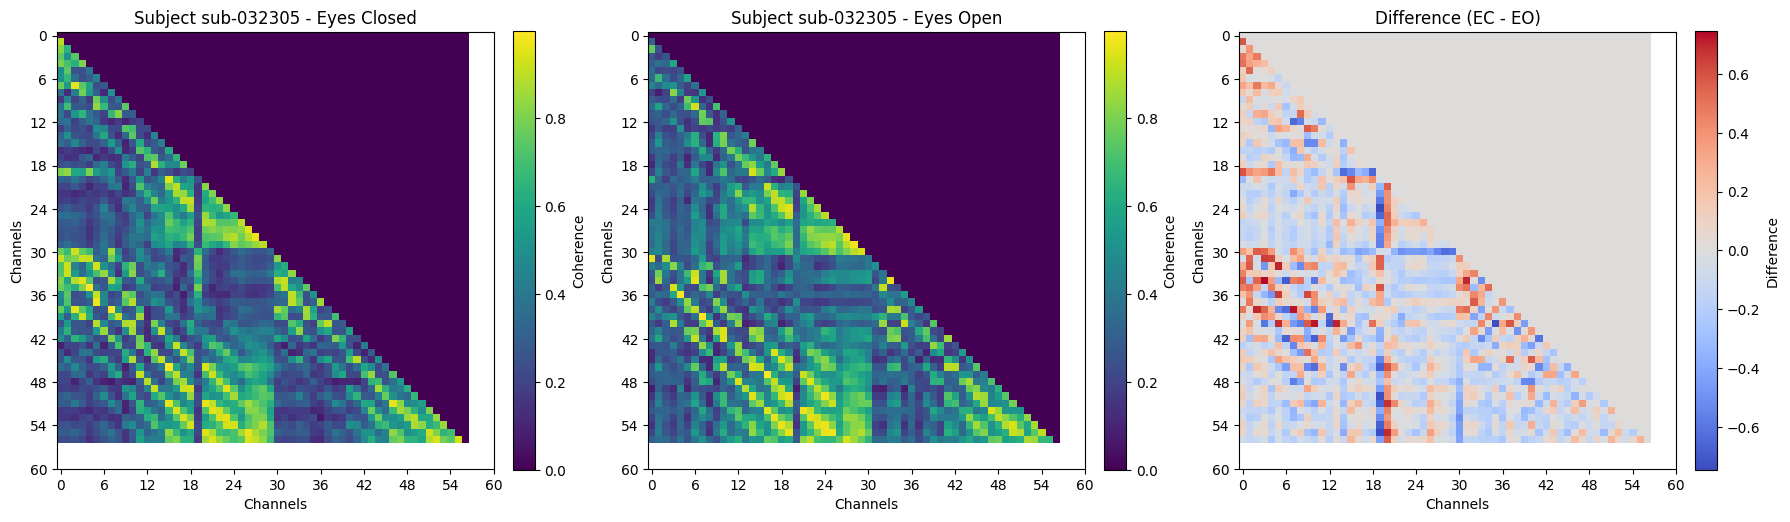

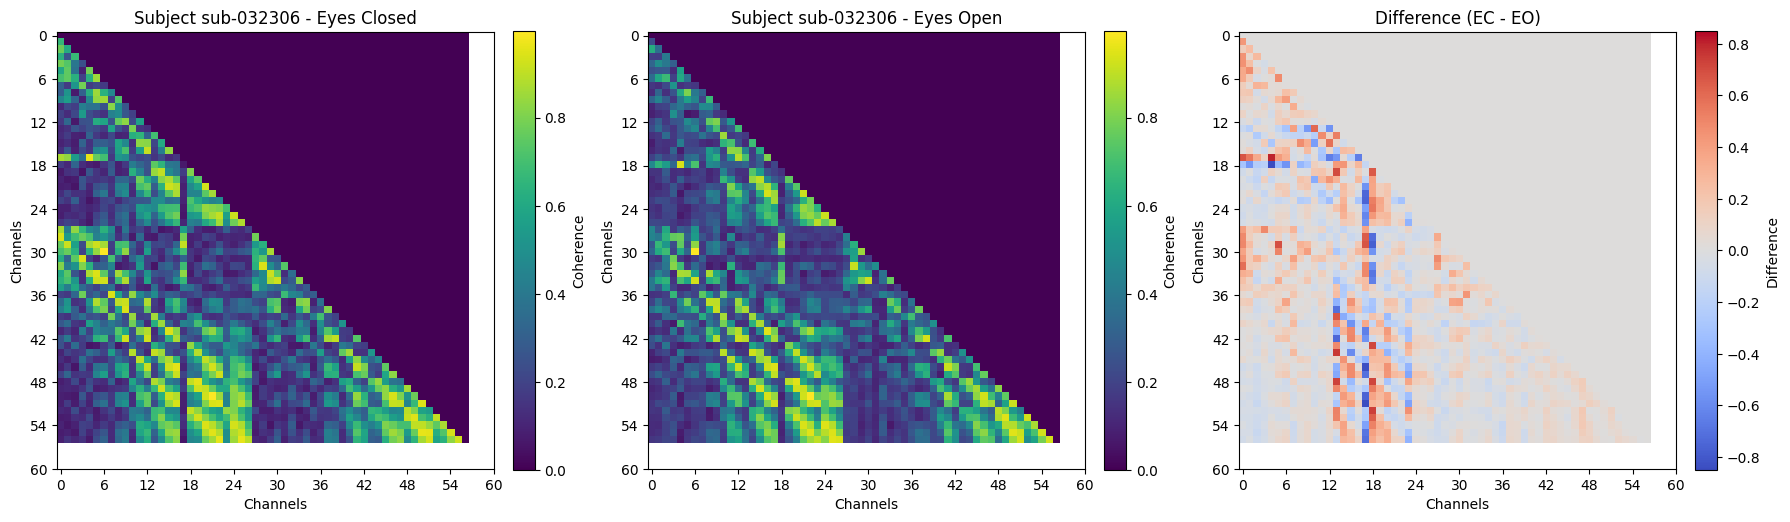

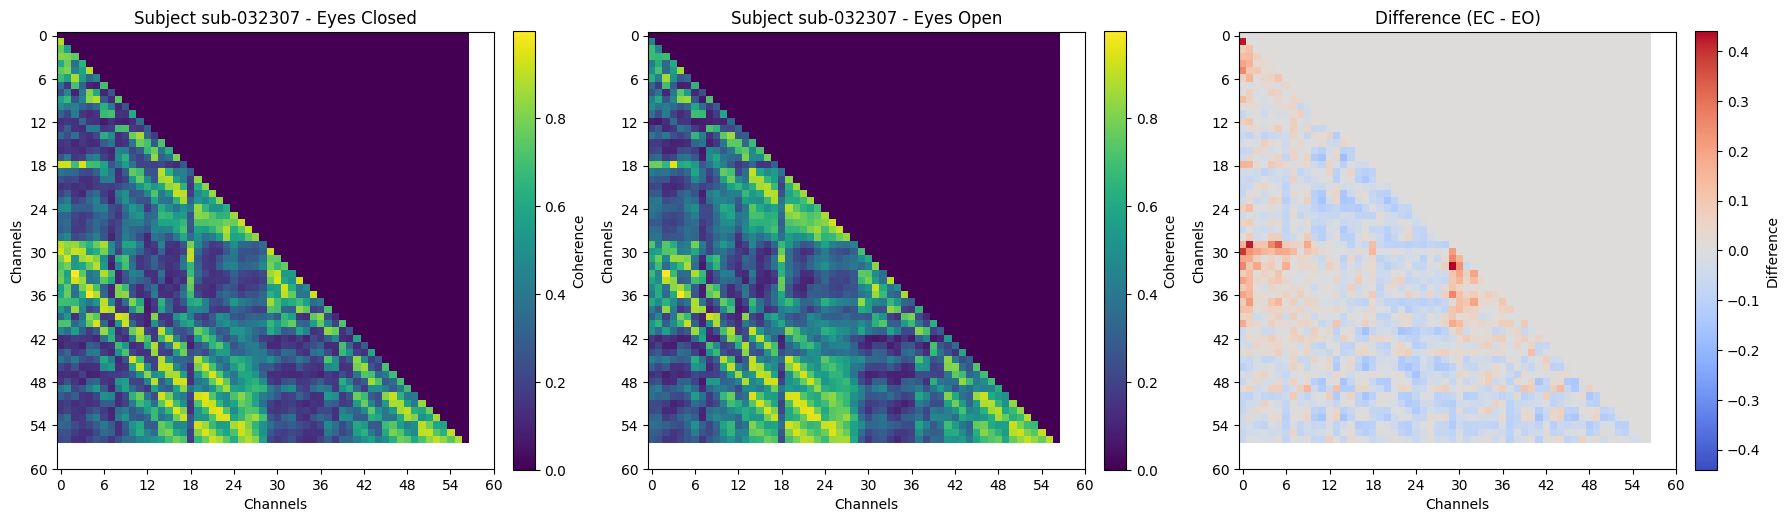

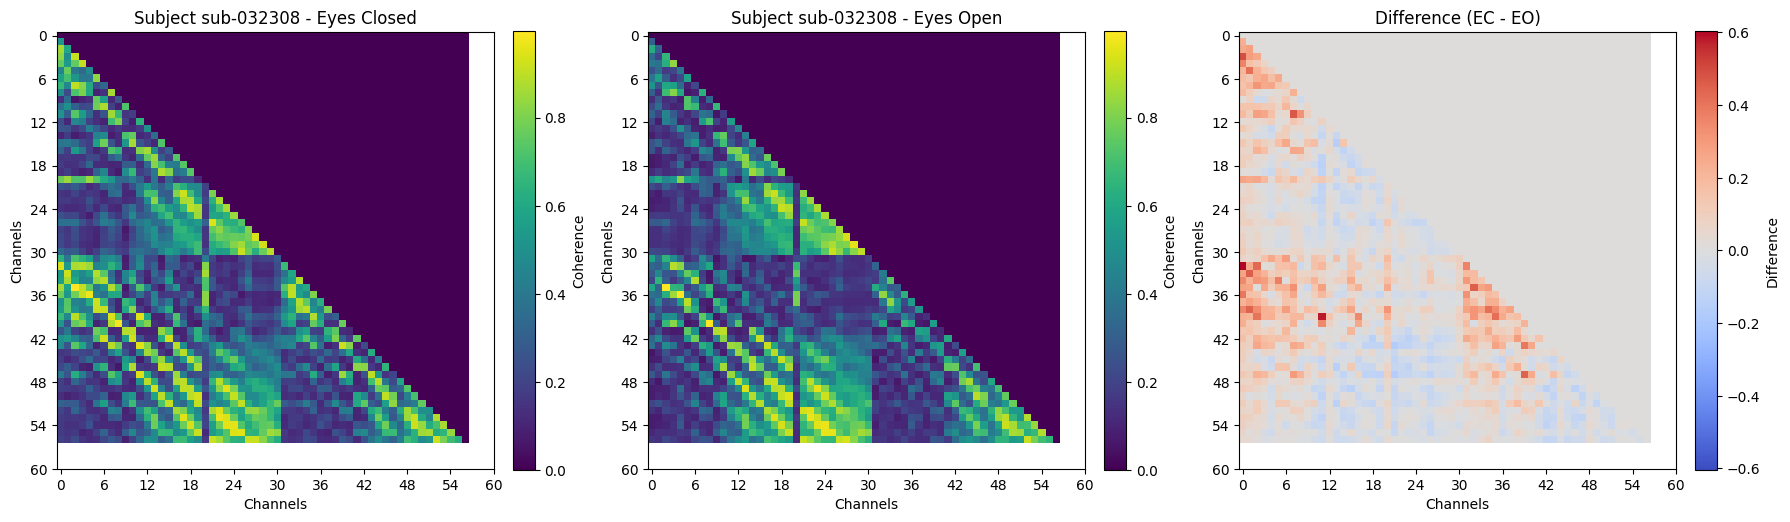

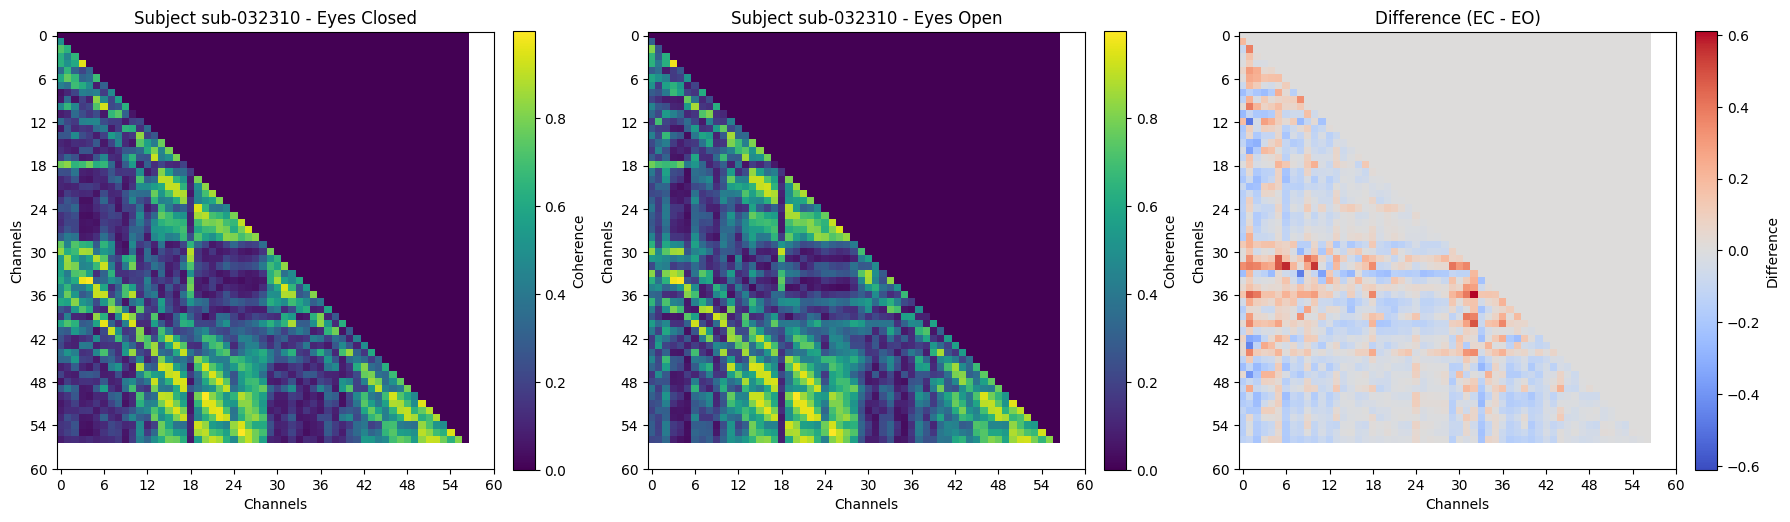

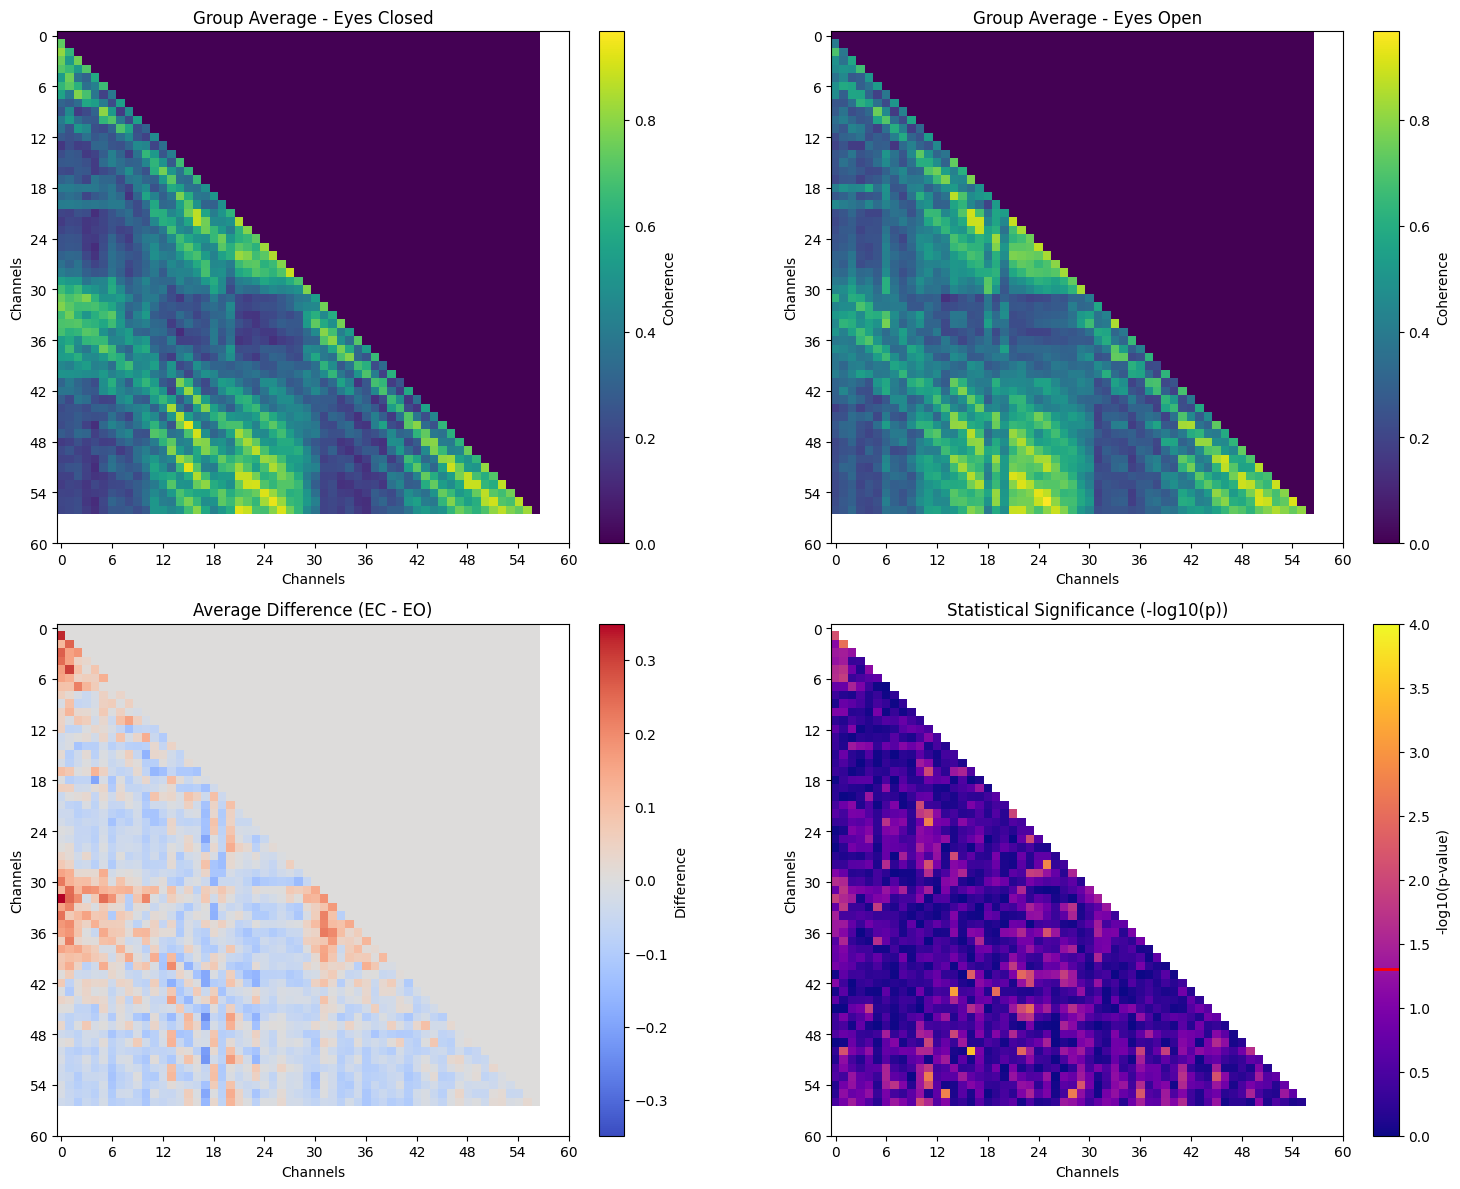

Plotting complete! 6 subjects processed.


In [30]:
original_ch_names = ('Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 'CP2', 'CP6', 'AFz', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT7', 'FC3', 'FC4', 'FT8', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8')
def align_channel_matrices(conn_list, ch_names):
    """
    Align connectivity matrices by removing consistently missing channels
    
    Parameters:
    -----------
    conn_list : list of dicts
        List of connectivity matrices for each subject
    ch_names : tuple or list of str
        List of channel names corresponding to matrix dimensions
    
    Returns:
    --------
    aligned_matrices : list of numpy arrays
        Connectivity matrices with consistent channels
    aligned_ch_names : list of str
        Updated channel names after alignment
    """
    # Convert ch_names to list if it's a tuple
    ch_names = list(ch_names)
    
    # Extract matrices from dictionaries (assuming a key like 'matrix' or similar)
    # You might need to adjust this based on your exact dictionary structure
    matrices = []
    for conn_dict in conn_list:
        # Find the matrix in the dictionary (adjust the key as needed)
        matrix = None
        for key in conn_dict.keys():
            if isinstance(conn_dict[key], np.ndarray) and conn_dict[key].ndim == 2:
                matrix = conn_dict[key]
                break
        
        if matrix is None:
            raise ValueError(f"Could not find a 2D matrix in dictionary: {conn_dict.keys()}")
        
        matrices.append(matrix)
    
    # Find the maximum number of channels 
    max_channels = max(matrix.shape[0] for matrix in matrices)
    
    # Track missing channels
    missing_channels = set()
    
    # Identify channels that are missing in ANY subject
    for matrix in matrices:
        # Channels missing in this matrix
        current_missing = set(ch_names) - set(ch_names[:matrix.shape[0]])
        missing_channels.update(current_missing)
    
    # Print out missing channels for transparency
    print("Channels being removed:", missing_channels)
    
    # Remove missing channels from channel names
    aligned_ch_names = [ch for ch in ch_names if ch not in missing_channels]
    
    # Align matrices
    aligned_matrices = []
    for matrix in matrices:
        # Find indices of channels to keep
        keep_indices = [ch_names.index(ch) for ch in aligned_ch_names 
                        if ch in ch_names[:matrix.shape[0]]]
        
        # Subset the matrix
        aligned_matrix = matrix[np.ix_(keep_indices, keep_indices)]
        aligned_matrices.append(aligned_matrix)
    
    print(f"Aligned matrices shape: {aligned_matrices[0].shape}")
    
    return aligned_matrices, aligned_ch_names

# Correct usage
ec_conn_aligned, aligned_ch_names = align_channel_matrices(ec_conn_list, original_ch_names)
eo_conn_aligned, _ = align_channel_matrices(eo_conn_list, original_ch_names)

# Then use these aligned matrices in your plotting functions
plot_all_subjects_and_group(
    ec_conn_aligned, 
    eo_conn_aligned, 
    subjects, 
    ch_names=aligned_ch_names, 
    output_dir=con_folder
)